# LBM tutorial

## hello world 

 

Note: 


 * In this tutorial we will use `%%bash` magic for running commands. If there is a need to configure e.g. conda  environment, setting once in the notebook `BASH_ENV` variable will force all `%%bash` cell to run given config file.
 * We will also assume that sailfish repository (or link to it) is in the tutorial directory.

In [12]:

%env BASH_ENV= ~/.bash_profile

env: BASH_ENV=~/.bash_profile


In [13]:
%%bash
ls  $HOME/sailfish -ld

drwxr-xr-x 12 marcin.kostur staff 4096 Nov 21 10:36 /home/users/marcin.kostur/sailfish


In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sys, os
sys.path.append('~/sailfish/')

datapath = os.path.join( "/dev/shm/",os.environ.get("USER"),"data")
try:
    os.makedirs(datapath,mode=0755)
except OSError as ex:
    print datapath,"::",ex.strerror

if not os.path.isdir('data') and os.path.islink('data'):
    os.remove("data")
    
if not os.path.islink('data'):
    os.symlink(datapath, "data")


/dev/shm/marcin.kostur/data :: File exists


In [15]:
%%writefile data/ex1.py
import numpy as np
from sailfish.subdomain import Subdomain2D
from sailfish.node_type import NTFullBBWall, NTEquilibriumVelocity
from sailfish.controller import LBSimulationController
from sailfish.lb_single import LBFluidSim

class MyBlock(Subdomain2D):
    max_v = 0.1

    def boundary_conditions(self, hx, hy):
        wall_map = ( (hx == self.gx-1) | (hx == 0) | (hy == 0) )
        self.set_node( (hy == self.gy-1) & (hx>0) & (hx<self.gx-1) , NTEquilibriumVelocity((self.max_v, 0.0)) )
        self.set_node(wall_map, NTFullBBWall)
        
    def initial_conditions(self, sim, hx, hy):
        sim.rho[:] = 1.0

class MySim(LBFluidSim):
    subdomain = MyBlock

LBSimulationController(MySim).run()

Overwriting data/ex1.py


The ex1.py program needs to know about the total number of iterations and the lattice size. It can be specified as the command line parameters.

Thus the simplest way to call this program is following:

In [16]:
%%bash 
export PYTHONPATH=$PWD/sailfish/
python data/ex1.py --max_iters=100 --lat_nx=32 --lat_ny=48

[   670  INFO Master/gpu4.smcebi.us.edu.pl] Machine master starting with PID 94796 at 2017-02-28 08:36:06 UTC
[   670  INFO Master/gpu4.smcebi.us.edu.pl] Simulation started with: data/ex1.py --max_iters=100 --lat_nx=32 --lat_ny=48
[   685  INFO Master/gpu4.smcebi.us.edu.pl] Sailfish version: dcc3d33d3c6fe420f78ff1af13471774ef283c74
[   685  INFO Master/gpu4.smcebi.us.edu.pl] Handling subdomains: [0]
[   685  INFO Master/gpu4.smcebi.us.edu.pl] Subdomain -> GPU map: {0: 0}
[   685  INFO Master/gpu4.smcebi.us.edu.pl] Selected backend: cuda
[   991  INFO Subdomain/0] Initializing subdomain.
[   993  INFO Subdomain/0] Required memory: 
[   993  INFO Subdomain/0] . distributions: 0 MiB
[   994  INFO Subdomain/0] . fields: 0 MiB
[  3056  INFO Subdomain/0] Starting simulation.
[  3072  INFO Subdomain/0] Simulation completed after 100 iterations.


The last command has:
    
- prepared D2Q9 kernel in CUDA-C language,
- given initial conditions ($\rho$ and $\vec u$) as numpy arrays, initialized distributions on the device,
- run 100 iterations on 32x48 lattice in D2Q9 LBM model,
- quit without writing out any data

The standard output to the command reveals that computations has been done on a single device with identifier `0`. 
The sailfish version  means the hash from github repository (in this case: https://github.com/sailfish-team/sailfish).





If one wants to see more information about the simulation process then  can be seen when flag `verbose=1` is set. 


In [17]:
%%bash 
export PYTHONPATH=$PWD/sailfish/
python data/ex1.py --max_iters=100 --lat_nx=32 --lat_ny=48 --verbose

[   795  INFO Master/gpu4.smcebi.us.edu.pl] Machine master starting with PID 94942 at 2017-02-28 08:36:20 UTC
[   795  INFO Master/gpu4.smcebi.us.edu.pl] Simulation started with: data/ex1.py --max_iters=100 --lat_nx=32 --lat_ny=48 --verbose
[   803  INFO Master/gpu4.smcebi.us.edu.pl] Sailfish version: dcc3d33d3c6fe420f78ff1af13471774ef283c74
[   803  INFO Master/gpu4.smcebi.us.edu.pl] Handling subdomains: [0]
[   803  INFO Master/gpu4.smcebi.us.edu.pl] Subdomain -> GPU map: {0: 0}
[   804  INFO Master/gpu4.smcebi.us.edu.pl] Selected backend: cuda
[   809 DEBUG Subdomain/0] SubdomainRunner starting with PID 94947
[  1094 DEBUG Master/gpu4.smcebi.us.edu.pl] Port map is: {}
[  1095  INFO Subdomain/0] Initializing subdomain.
[  1096 DEBUG Subdomain/0] Tesla K40m / CC (3, 5) / MEM 11995578368
[  1096 DEBUG Subdomain/0] Initializing geometry.
[  1096 DEBUG Subdomain/0] Effective lattice size is: [64, 50]
[  1096 DEBUG Subdomain/0] Disabling bulk/boundary split.
[  1096 DEBUG Subdomain/0] Bul

### Output

In the case of 2d simulation a very convenient format for fields on a regular lattice in a numpy array. We  can ask sailfish to write to numpy files with "casename" `ex1` in the directory `data` by:
  
  `--output=data/ex1 --output_format=npy`

Except debugging purposes it is not very efficient to store all macroscopic fields every simulation step. Current GPU devices can produce Terabytes of data in few seconds, thus they must be processed within a GPU device. The simple way to limit the output is to use:

 - `--from=123` - start output from  123-th iteration, when not given it starts from 0-th
 - `--every=100` - output every 100-th iteration, files will have a iteration number in a filename
 
 If we wanted to store the initial condition and the final step the following line should be executed:
  
   
   

In [18]:
%%bash 
export PYTHONPATH=$PWD/sailfish/
python data/ex1.py --max_iters=1000 --every=1000 \
 --lat_nx=32 --lat_ny=48 \
 --output=data/ex1 --output_format=npy

[   784  INFO Master/gpu4.smcebi.us.edu.pl] Machine master starting with PID 95065 at 2017-02-28 08:36:28 UTC
[   784  INFO Master/gpu4.smcebi.us.edu.pl] Simulation started with: data/ex1.py --max_iters=1000 --every=1000 --lat_nx=32 --lat_ny=48 --output=data/ex1 --output_format=npy
[   792  INFO Master/gpu4.smcebi.us.edu.pl] Sailfish version: dcc3d33d3c6fe420f78ff1af13471774ef283c74
[   792  INFO Master/gpu4.smcebi.us.edu.pl] Handling subdomains: [0]
[   792  INFO Master/gpu4.smcebi.us.edu.pl] Subdomain -> GPU map: {0: 0}
[   792  INFO Master/gpu4.smcebi.us.edu.pl] Selected backend: cuda
[  1089  INFO Subdomain/0] Initializing subdomain.
[  1091  INFO Subdomain/0] Required memory: 
[  1091  INFO Subdomain/0] . distributions: 0 MiB
[  1092  INFO Subdomain/0] . fields: 0 MiB
[  2791  INFO Subdomain/0] Starting simulation.
[  2898  INFO Subdomain/0] Simulation completed after 1000 iterations.


We can look at  files with ex1 prefix in data directory:

In [19]:
!ls data/ex1* -rtla

-rw-r--r-- 1 marcin.kostur staff   705 Feb 28 09:36 data/ex1.py
-rw-r--r-- 1 marcin.kostur staff   586 Feb 28 09:36 data/ex1.subdomains
-rw-r--r-- 1 marcin.kostur staff   493 Feb 28 09:36 data/ex1.0.0000.npz
-rw-r--r-- 1 marcin.kostur staff 15121 Feb 28 09:36 data/ex1.0.1000.npz


The macroscopic fields are written to `numpy` files, so we could open them with `np.load` function. It contains self explanatory names of the fields:

In [20]:
data = np.load("data/ex1.0.1000.npz")
data.files

['rho', 'v']

In [21]:
np.nanmin(data['rho'])

0.78508025

Scalar fields are simply $48 \times 32$ arrays. The physial $x$-axis  corresponds to the fastest changing index in the numpy array (C-convention by default). Thus arrays used in sailfish are "xy"-indexing style (see http://docs.scipy.org/doc/numpy/reference/generated/numpy.meshgrid.html)

Thus in matrix notation $a_{ij}$, or `a[i,j]`:

 * $x \iff j$
 * $y \iff i$

Vector field are stored component by component (SoA, not AoS), and have one axis more:

In [22]:
print data['rho'].shape
print data['v'].shape
print data['v'][0].shape

(48, 32)
(2, 48, 32)
(48, 32)


It is convenient to assign new variables for $x$ and $y$- component of the velocity:

In [23]:
vx,vy = data['v']
vy.shape

(48, 32)

One can retrieve from output data the size of the lattice, for example by:

In [24]:
ny,nx = vx.shape

then we can plot the ordered data using fast routine `imshow` (with no interpolation):

In [31]:
vx[np.isnan(vx)] = 0
vy[np.isnan(vy)] = 0

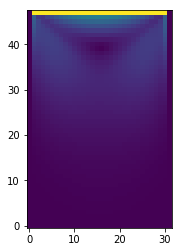

In [32]:
plt.imshow(np.sqrt(vx**2+vy**2),origin='top',interpolation='nearest')

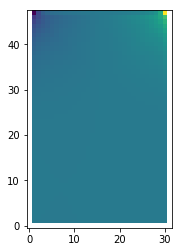

In [33]:
plt.imshow(data['rho'],origin='top',interpolation='nearest')

In [34]:
Y,X = np.mgrid[0:ny,0:nx]

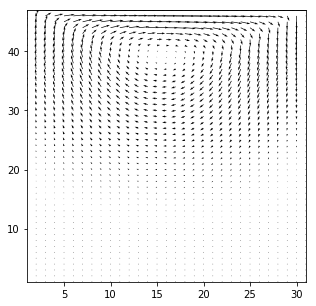

In [35]:
plt.figure(figsize=(5,5))
plt.xlim(1,nx-1)
plt.ylim(1,ny-1)
plt.quiver(X,Y,vx,vy)

In [36]:
vx.shape,X.shape


((48, 32), (48, 32))

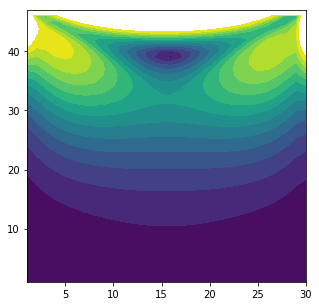

In [39]:
plt.figure(figsize=(5,ny/nx*5))
plt.xlim(1,nx-2)
plt.ylim(1,ny-1)
plt.contourf(X,Y,np.sqrt(vy**2+vx**2),np.linspace(0.,0.02,14))

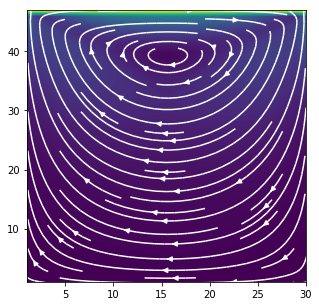

In [40]:
plt.figure(figsize=(5,ny/nx*5))
plt.xlim(1,nx-2)
plt.ylim(1,ny-1)

plt.contourf(X,Y,np.sqrt(vy**2+vx**2),256)
plt.streamplot(X,Y,vx,vy,color='white')


**Note:** the difference in default `mgrid` and `meshgrid`:

In [41]:
np.mgrid[0:4,0:4][0]

array([[0, 0, 0, 0],
       [1, 1, 1, 1],
       [2, 2, 2, 2],
       [3, 3, 3, 3]])

In [42]:
x = np.linspace(0,3,4)
X,Y = np.meshgrid(x,x)
X

array([[ 0.,  1.,  2.,  3.],
       [ 0.,  1.,  2.,  3.],
       [ 0.,  1.,  2.,  3.],
       [ 0.,  1.,  2.,  3.]])

## Inspection of internal indexarrays in Subdomain class

Indexarrays `hx, hy, (hz)` are used to conveniently  define geometry in e.g. `boundary_conditions` function. 

We can save them and inspect.

In [43]:
%%writefile data/ex2.py
import numpy as np
from sailfish.subdomain import Subdomain2D
from sailfish.node_type import NTFullBBWall, NTEquilibriumVelocity
from sailfish.controller import LBSimulationController
from sailfish.lb_single import LBFluidSim

class MyBlock(Subdomain2D):
    max_v = 0.1

    def boundary_conditions(self, hx, hy):
        wall_map = ( (hx == self.gx-1) | (hx == 0) | (hy == 0) )
        self.set_node( (hy == self.gy-1) & (hx>0) & (hx<self.gx-1) , NTEquilibriumVelocity((self.max_v, 0.0)) )
        self.set_node(wall_map, NTFullBBWall)
        np.savez("data/hx.npz",hx=hx,hy=hy)
    def initial_conditions(self, sim, hx, hy):
        sim.rho[:] = 1.0
        
class MySim(LBFluidSim):
    subdomain = MyBlock

LBSimulationController(MySim).run()

Writing data/ex2.py


In [44]:
%%bash
export PYTHONPATH=$PWD/sailfish/
python data/ex2.py --max_iters=100 --lat_nx=32 --lat_ny=32

[   706  INFO Master/gpu4.smcebi.us.edu.pl] Machine master starting with PID 95255 at 2017-02-28 08:41:26 UTC
[   706  INFO Master/gpu4.smcebi.us.edu.pl] Simulation started with: data/ex2.py --max_iters=100 --lat_nx=32 --lat_ny=32
[   720  INFO Master/gpu4.smcebi.us.edu.pl] Sailfish version: dcc3d33d3c6fe420f78ff1af13471774ef283c74
[   720  INFO Master/gpu4.smcebi.us.edu.pl] Handling subdomains: [0]
[   721  INFO Master/gpu4.smcebi.us.edu.pl] Subdomain -> GPU map: {0: 0}
[   721  INFO Master/gpu4.smcebi.us.edu.pl] Selected backend: cuda
[  1015  INFO Subdomain/0] Initializing subdomain.
[  1017  INFO Subdomain/0] Required memory: 
[  1018  INFO Subdomain/0] . distributions: 0 MiB
[  1018  INFO Subdomain/0] . fields: 0 MiB
[  3127  INFO Subdomain/0] Starting simulation.
[  3143  INFO Subdomain/0] Simulation completed after 100 iterations.


In [51]:
!ls -lta data/hx*

-rw-r--r-- 1 marcin.kostur staff 18854 Feb 28 09:41 data/hx.npz


In [52]:
data = np.load("data/hx.npz")
hx = data['hx']
hy = data['hy']

In [53]:
hx

array([[-1,  0,  1, ..., 30, 31, 32],
       [-1,  0,  1, ..., 30, 31, 32],
       [-1,  0,  1, ..., 30, 31, 32],
       ..., 
       [-1,  0,  1, ..., 30, 31, 32],
       [-1,  0,  1, ..., 30, 31, 32],
       [-1,  0,  1, ..., 30, 31, 32]])

Note that indices vary from -1 to nx. It is because of present ghost node. This, however is not changing arithmetics in geometry manupulation.

In [54]:
(hx>0)

array([[False, False,  True, ...,  True,  True,  True],
       [False, False,  True, ...,  True,  True,  True],
       [False, False,  True, ...,  True,  True,  True],
       ..., 
       [False, False,  True, ...,  True,  True,  True],
       [False, False,  True, ...,  True,  True,  True],
       [False, False,  True, ...,  True,  True,  True]], dtype=bool)

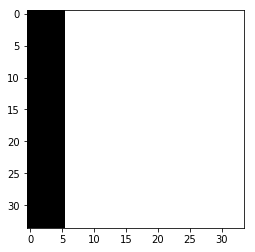

In [57]:
plt.imshow(hx>4,interpolation='nearest',cmap='gray')

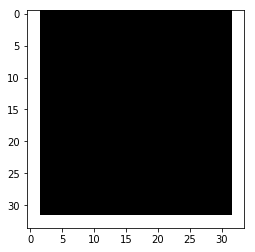

In [58]:
plt.imshow( (hy>30)|(hx<1) | (hx>30),interpolation='nearest',cmap='gray') 

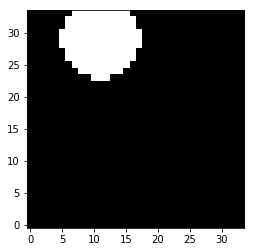

In [59]:
plt.imshow( (hx-10)**2+(hy-28)**2<6.2**2,interpolation='nearest',cmap='gray',origin='top') 

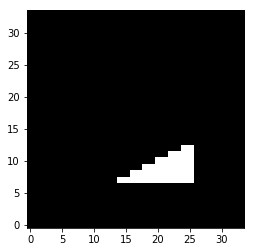

In [60]:
plt.imshow( (hy>5)&(hy<24)&(hx>10)&(hx<25)&(hx>2*hy),interpolation='nearest',cmap='gray',origin='top') 

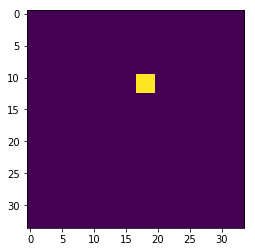

In [61]:
x0,y0,a = 15,8,4
plt.imshow( (hx>x0) & (hx<x0+a) & (hy>y0) & (hy<y0+a),interpolation='nearest') 

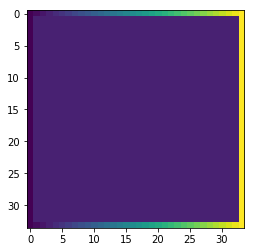

In [62]:
hx[1:-1,1:-1] = 2
plt.imshow(hx)

### Simulation with user defined geometry.

In [63]:
%%writefile data/ex3.py
import numpy as np
from sailfish.subdomain import Subdomain2D
from sailfish.node_type import NTFullBBWall, NTEquilibriumVelocity
from sailfish.controller import LBSimulationController
from sailfish.lb_single import LBFluidSim

class MyBlock(Subdomain2D):

    def boundary_conditions(self, hx, hy):
        wall_map = ( (hx == self.gx-1) | (hx == 0) | (hy == 0) | (hy == self.gy-1) )
        self.set_node(wall_map, NTFullBBWall)
        x0,y0,a = 15,8,4
        square_map = (hx>x0) & (hx<x0+a) & (hy>y0) & (hy<y0+a)
        self.set_node( square_map , NTEquilibriumVelocity(( 0.1, 0.1)) )
        x0,y0,a = 15+6,8+6,4
        square_map = (hx>x0) & (hx<x0+a) & (hy>y0) & (hy<y0+a)
        self.set_node(square_map, NTFullBBWall)
        
    def initial_conditions(self, sim, hx, hy):
        sim.rho[:] = 1.0
        #sim.vx[hy == self.gy-1] = self.max_v


class MySim(LBFluidSim):
    subdomain = MyBlock

LBSimulationController(MySim).run()

Writing data/ex3.py


In [64]:
%%bash
export PYTHONPATH=$PWD/sailfish/
python data/ex3.py --max_iters=1000 --every=1000 \
 --lat_nx=32 --lat_ny=32 \
 --visc=0.1002 \
 --output=data/ex3 --output_format=npy

[   669  INFO Master/gpu4.smcebi.us.edu.pl] Machine master starting with PID 95507 at 2017-02-28 08:45:38 UTC
[   669  INFO Master/gpu4.smcebi.us.edu.pl] Simulation started with: data/ex3.py --max_iters=1000 --every=1000 --lat_nx=32 --lat_ny=32 --visc=0.1002 --output=data/ex3 --output_format=npy
[   683  INFO Master/gpu4.smcebi.us.edu.pl] Sailfish version: dcc3d33d3c6fe420f78ff1af13471774ef283c74
[   683  INFO Master/gpu4.smcebi.us.edu.pl] Handling subdomains: [0]
[   683  INFO Master/gpu4.smcebi.us.edu.pl] Subdomain -> GPU map: {0: 0}
[   684  INFO Master/gpu4.smcebi.us.edu.pl] Selected backend: cuda
[   990  INFO Subdomain/0] Initializing subdomain.
[   992  INFO Subdomain/0] Required memory: 
[   992  INFO Subdomain/0] . distributions: 0 MiB
[   992  INFO Subdomain/0] . fields: 0 MiB
[  3120  INFO Subdomain/0] Starting simulation.
[  3237  INFO Subdomain/0] Simulation completed after 1000 iterations.


In [66]:
!ls -lrta data/ex3*


-rw-r--r-- 1 marcin.kostur staff  945 Feb 28 09:45 data/ex3.py
-rw-r--r-- 1 marcin.kostur staff  586 Feb 28 09:45 data/ex3.subdomains
-rw-r--r-- 1 marcin.kostur staff  495 Feb 28 09:45 data/ex3.0.0000.npz
-rw-r--r-- 1 marcin.kostur staff 9912 Feb 28 09:45 data/ex3.0.1000.npz


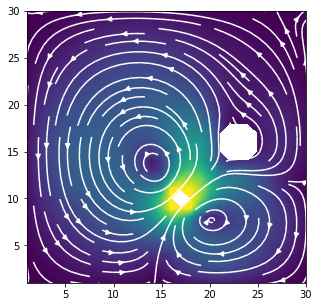

In [67]:
data = np.load("data/ex3.0.1000.npz")
vx,vy = data['v']

ny,nx = vx.shape
Y,X = np.mgrid[0:ny,0:nx]
plt.figure(figsize=(5,ny/nx*5))
plt.xlim(1,nx-2)
plt.ylim(1,ny-2)
plt.contourf(X,Y,np.sqrt(vy**2+vx**2),256)
vy[np.isnan(vy)] = 0.0
vx[np.isnan(vx)] = 0.0
plt.streamplot(X,Y,vx,vy,color='white')


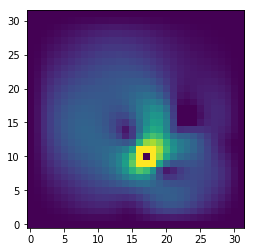

In [68]:
plt.imshow(np.sqrt(vy**2+vx**2),interpolation='none',origin='top')

In [70]:
%%writefile data/ex3a.py
import numpy as np
from sailfish.subdomain import Subdomain2D
from sailfish.node_type import NTFullBBWall, NTEquilibriumVelocity
from sailfish.controller import LBSimulationController
from sailfish.lb_single import LBFluidSim

class MyBlock(Subdomain2D):

    def boundary_conditions(self, hx, hy):
        wall_map = ( (hx == self.gx-1) | (hx == 0) | (hy == 0) | (hy == self.gy-1) )
        self.set_node(wall_map, NTFullBBWall)
        x0,y0,a = 15,8,4
        #square_map = (hx>x0) & (hx<x0+a) & (hy>y0) & (hy<y0+a)
        square_map =(hy>10)&(hy<20)&(hx>10)&(hx<20)&(hx>2*hy)
        square_map = (hy>5)&(hy<24)&(hx>10)&(hx<25)&(hx>2*hy)
        self.set_node( square_map , NTEquilibriumVelocity(( -0.2, 0.1)) )
        x0,y0,a = 15+6,8+6,4
        square_map = (hx>x0) & (hx<x0+a) & (hy>y0) & (hy<y0+a)
        #self.set_node(square_map, NTFullBBWall)
        
    def initial_conditions(self, sim, hx, hy):
        sim.rho[:] = 1.0
        #sim.vx[hy == self.gy-1] = self.max_v


class MySim(LBFluidSim):
    subdomain = MyBlock

LBSimulationController(MySim).run()

Overwriting data/ex3a.py


In [71]:
%%bash
export PYTHONPATH=$PWD/sailfish/
python data/ex3a.py --max_iters=1000 --every=1000 \
 --lat_nx=132 --lat_ny=132 \
 --visc=0.0102 \
 --output=data/ex3 --output_format=npy

[   739  INFO Master/gpu4.smcebi.us.edu.pl] Machine master starting with PID 95703 at 2017-02-28 08:46:44 UTC
[   740  INFO Master/gpu4.smcebi.us.edu.pl] Simulation started with: data/ex3a.py --max_iters=1000 --every=1000 --lat_nx=132 --lat_ny=132 --visc=0.0102 --output=data/ex3 --output_format=npy
[   754  INFO Master/gpu4.smcebi.us.edu.pl] Sailfish version: dcc3d33d3c6fe420f78ff1af13471774ef283c74
[   754  INFO Master/gpu4.smcebi.us.edu.pl] Handling subdomains: [0]
[   754  INFO Master/gpu4.smcebi.us.edu.pl] Subdomain -> GPU map: {0: 0}
[   754  INFO Master/gpu4.smcebi.us.edu.pl] Selected backend: cuda
[  1049  INFO Subdomain/0] Initializing subdomain.
[  1051  INFO Subdomain/0] Required memory: 
[  1051  INFO Subdomain/0] . distributions: 1 MiB
[  1051  INFO Subdomain/0] . fields: 0 MiB
[  3129  INFO Subdomain/0] Starting simulation.
[  3269  INFO Subdomain/0] Simulation completed after 1000 iterations.


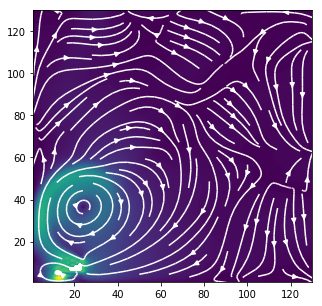

In [72]:
data = np.load("data/ex3.0.1000.npz")
vx,vy = data['v']
ny,nx = vx.shape
Y,X = np.mgrid[0:ny,0:nx]
plt.figure(figsize=(5,ny/nx*5))
plt.xlim(1,nx-2)
plt.ylim(1,ny-2)
plt.contourf(X,Y,np.sqrt(vy**2+vx**2),256)
vy[np.isnan(vy)] = 0.0
vx[np.isnan(vx)] = 0.0
plt.streamplot(X,Y,vx,vy,color='white')
